You will work through an example project end to end, pretending to be a recently hired data scientist at a real estate company. The goal is to illustrate the main steps of a machine learning project, here are the main steps we will walk through:

1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data to gain insights.
4. Prepare the data for machine learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

# 1. Look at the big picture

Your first task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). I will call them “districts” for short.

Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

## Frame the Problem

Knowing the objective is important because it will determine how you frame the problem, which algorithms you will select, which performance measure you will use to evaluate your model, and how much effort you will spend tweaking it. A machine learning pipeline for real estate investments:

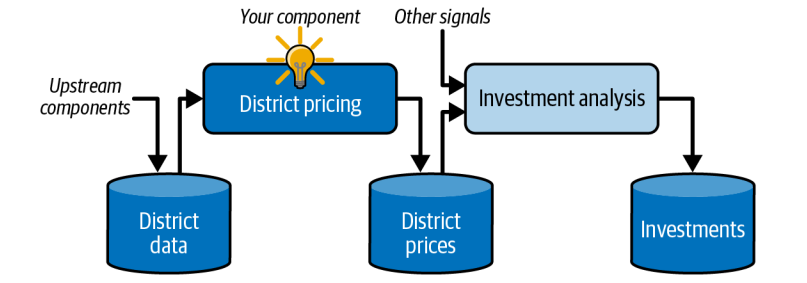

With all this information, you are now ready to start designing your system. First, determine what kind of training supervision the model will need.

## Select a Performance Measure

A typical performance measure for regression problems is the root mean square error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight given to large errors:

$$\text{RMSE}(\mathbf{X}, h) = \sqrt{\frac{1}{m}\sum_{i=1}^m[h(\mathbf{x}^{(i)}) - y^{(i)}]^2}$$

Ff there are many outlier districts. In that case, you may consider using the mean absolute error (MAE, also called the average absolute deviation):

$$\text{MAE}(\mathbf{X}, h) = \frac{1}{m}\sum_{i=1}^m|h(\mathbf{x}^{(i)}) - y^{(i)}|$$

## Check the Assumptions

For example, the district prices that your system outputs are going to be fed into a downstream machine learning system, and you assume that these prices are going to be used as such. But what if the downstream system converts the prices into categories (e.g., “cheap”, “medium”, or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task.

# 2. Get the data

## Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Take a Quick Look at the Data Structure

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

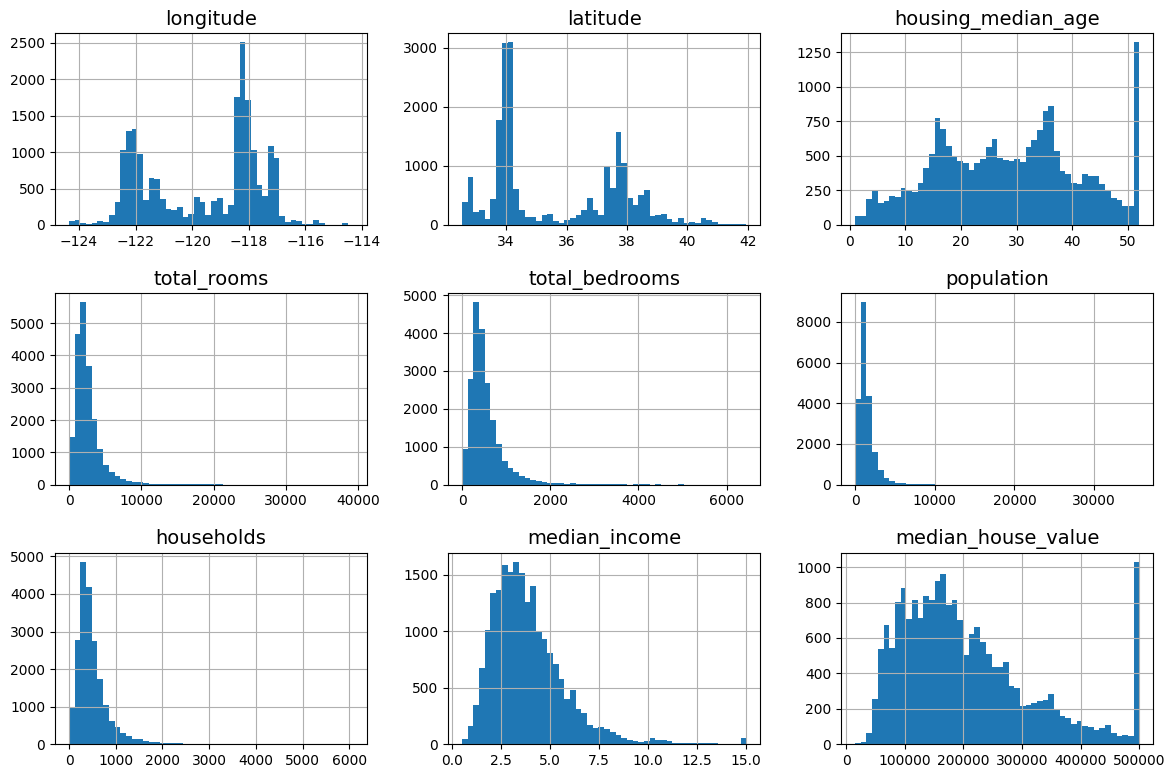

In [5]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

Looking at these histograms, you notice a few things:

+ First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).
+ The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your machine learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise
predictions even beyond $500,000, then you have two options:
    - Collect proper labels for the districts whose labels were capped.
    - Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).
+ These attributes have very different scales. We will discuss this later.
+ Finally, many histograms are skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some machine learning algorithms to detect patterns. Later, you’ll try transforming these attributes to have more symmetrical and bell-shaped distributions.

## Create a Test Set

In [6]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [8]:
len(test_set)

4128

In [9]:
np.random.seed(42)

*A method for maintaining a consistent train/test split even when the dataset is updated:* The method involves using each instance’s unique identifier to determine if it should be in the test set. This is done by computing a hash of the identifier and including the instance in the test set if the hash is less than or equal to 20% of the maximum hash value. This ensures that the test set remains consistent across multiple runs, even when the dataset is refreshed. The updated test set will contain 20% of the new instances, but will not include any instances that were previously in the training set. Here is a possible implementation:

In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Explanation for the code:

+ The `crc32` function from the `zlib` module in Python takes a byte string and returns a 32-bit hash value of that byte string.

+ `is_id_in_test_set(identifier, test_ratio)`: This function checks whether an `identifier` belongs to the test data set, based on the `test_ratio` ratio. To do this, the function uses the `crc32` function from the `zlib` module to calculate the hash value of the `identifier`. If the hash value is less than `test_ratio * 2**32`, then `identifier` is considered to belong to the test data set.

+ In the `is_id_in_test_set` function, `np.int64(identifier)` is used to ensure that the `identifier` is converted to numpy's int64 data type before being passed to the `crc32` function. The reason for this is that the `crc32` function requires the input to be a byte string. If `identifier` is not an integer, converting it to `np.int64` will ensure that it can be validly converted to a byte string. Additionally, using `np.int64` also ensures that the identifier will have the same data type on all platforms. This is important because the default data type of an integer can change depending on the platform (for example, 32-bit or 64-bit). By using `np.int64`, you ensure that the identifier will always be 64-bit, regardless of the platform.

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [11]:
housing_with_id = housing.reset_index()  # adds an `index` column
housing_with_id

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [12]:
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
housing_with_id

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,-121050.52
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,-121170.51
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,-121180.57
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,-121280.57


In [14]:
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split()`, which does pretty much the same thing as the `shuffle_and_split_data()` function we defined earlier

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
test_set["total_bedrooms"].isnull().sum()

44

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [17]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


Suppose you’ve chatted with some experts who told you that **the median income is a very important attribute to predict median housing prices**. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The
following code uses the `pd.cut()` function to create an income category attribute with five categories (labeled from 1 to 5); category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

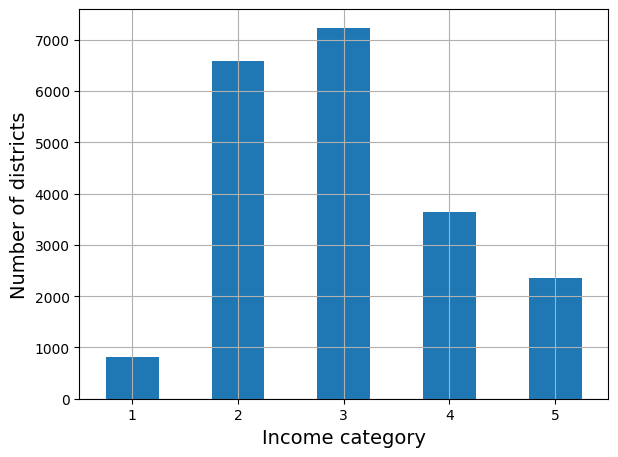

In [19]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True) #`rot=0` makes the x-axis labels horizontal
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

Now you are ready to do stratified sampling based on the income category. Scikit-Learn provides a number of splitter classes in the `sklearn.model_selection` package that implement various strategies to split your dataset into a training set and a test set. Each splitter has a `split()` method that returns an iterator over different training/ test splits of the same data.

To be precise, the `split()` method yields the training and test indices, not the data itself. For example, the following code generates 10 different stratified splits of the same dataset:

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [21]:
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split:

In [22]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [23]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN,2
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND,2
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN,4
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY,4


In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

With similar code you can measure the income category proportions in the full dataset.

In [25]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.

You won’t use the income_cat column again, so you might as well drop it, reverting the data back to its original state:

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 3. Explore and visualize the data to gain insights

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast during the exploration phase. In this case, the training set is quite small, so you can just work directly on the full set. Since you’re going to experiment with various transformations of the full training set, you should make a copy of the original so you can revert to it afterwards:

In [27]:
housing = strat_train_set.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN


## Visualizing Geographical Data

Because the dataset includes geographical information (`latitude` and `longitude`), it is a good idea to create a scatterplot of all the districts to visualize the data:

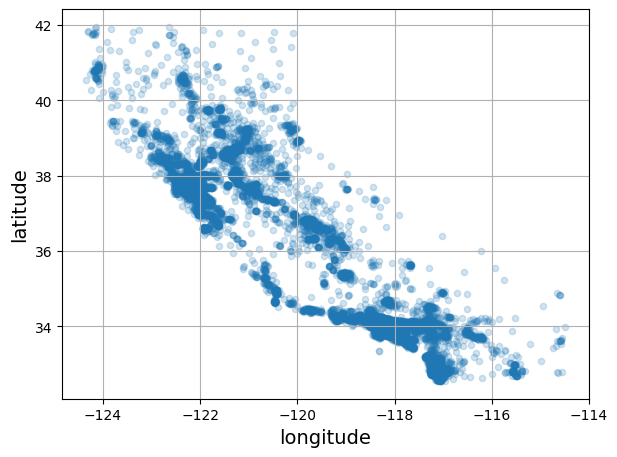

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=.2)
save_fig("bad_visualization_plot")  # extra code
plt.show()

Next, the radius of each circle represents the district’s population (option `s`), and the color represents the price (option `c`). Here you use a predefined color map (option `cmap`) called jet, which ranges from blue (low values) to red (high prices):

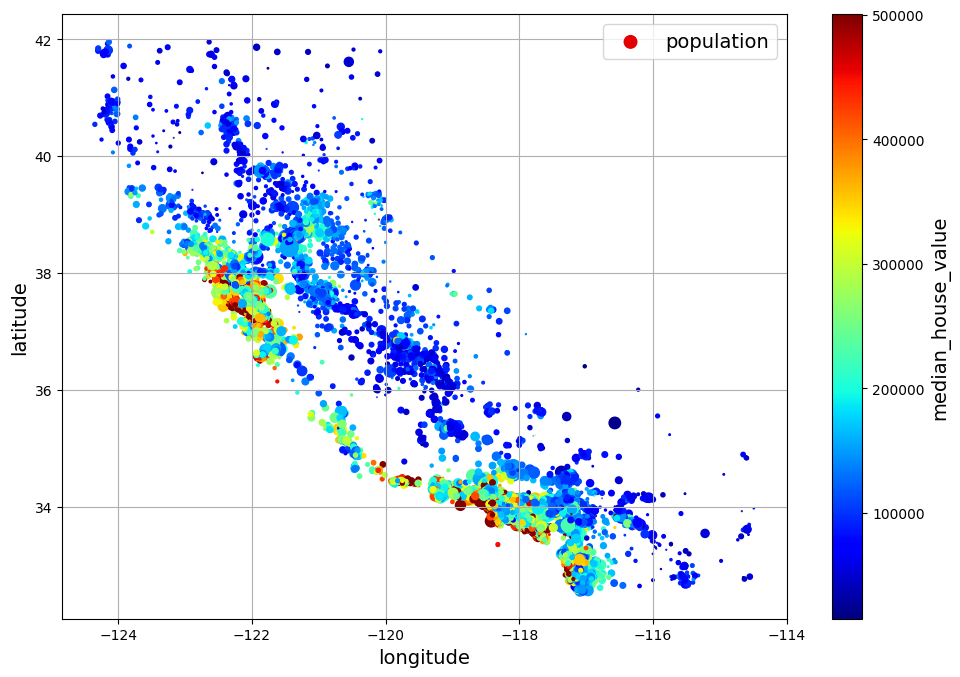

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100, label="population", c="median_house_value", cmap="jet",
             colorbar=True, legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

*Figure: California housing prices: red is expensive, blue is cheap, larger circles indicate areas with a larger population*

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

$\text{Note:}$ The argument `sharex=False` fixes a display bug: without it, the x-axis values and label are not displayed ([see](https://github.com/pandas-dev/pandas/issues/10611)).

It's just a beautified version of the previous figure, with an image of California added in the background, nicer label names and no grid.

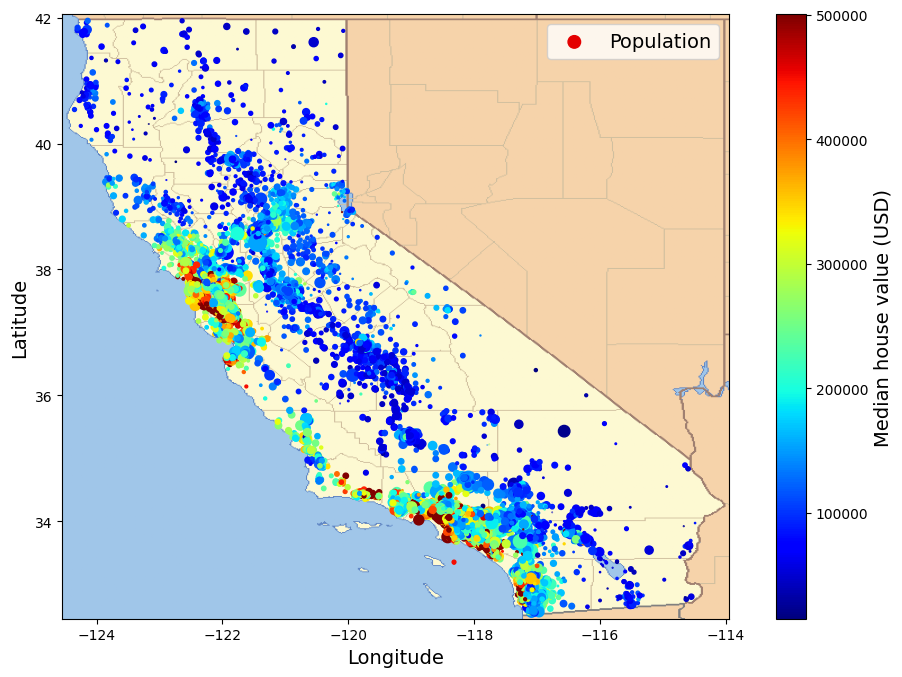

In [30]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", 
    "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", s=housing_renamed["Population"] / 100, label="Population", c="Median house value (USD)", 
                     cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))

"""
The first line uses the imread function to read the image from the file specified by the filename variable. 
The results are stored in the `california_img` variable. The `imread` function returns a numpy array containing the image data.
"""
california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)

"""
Finally, the line `plt.imshow(california_img, extent=axis)` uses the `imshow` function to display the `california_img` image on the graph. 
The `extent=axis` parameter is used to determine the position and size of the image on the graph based on the x-axis and y-axis limits previously defined.
"""
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

## Look for Correlations

$\text{Note}:$ since Pandas 2.0.0, the `numeric_only` argument defaults to `False`, so we need to set it explicitly to True to avoid an error.

In [31]:
corr_matrix = housing.corr(numeric_only=True)

In [32]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use the Pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute.

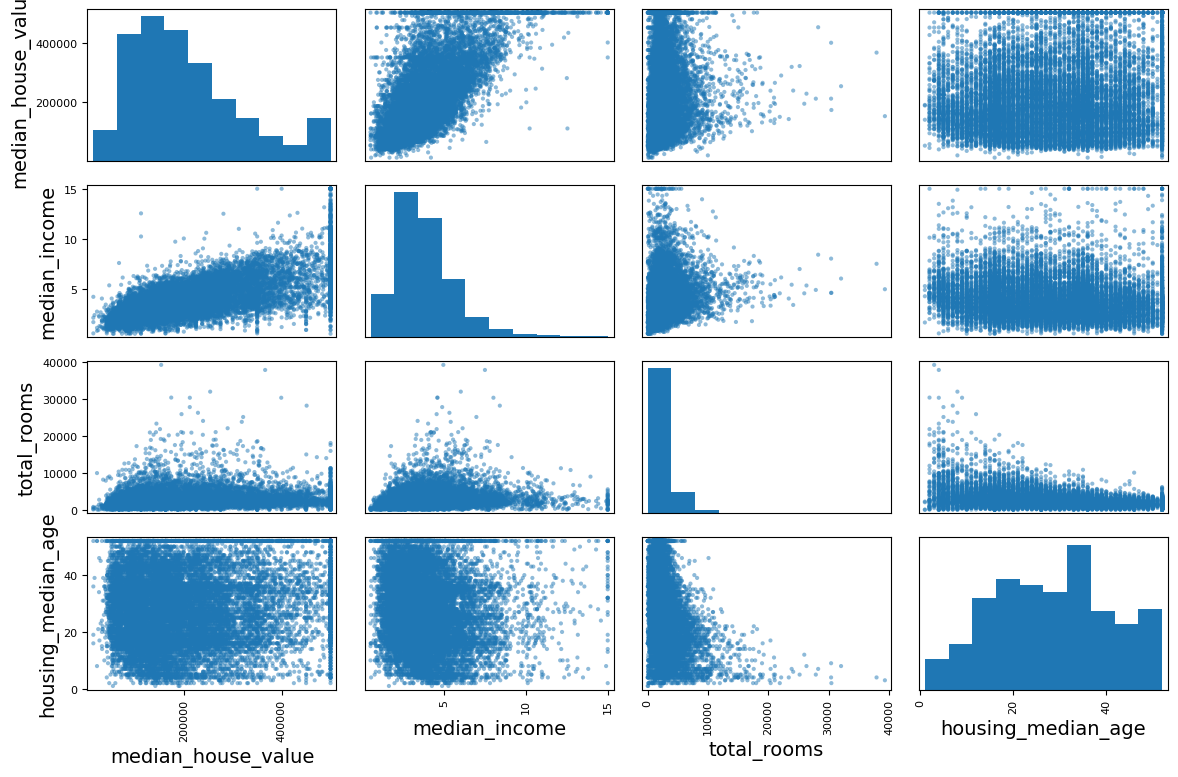

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

Looking at the correlation scatterplots, it seems like the most promising attribute to predict the median house value is the median income, so you zoom in on their scatterplot:

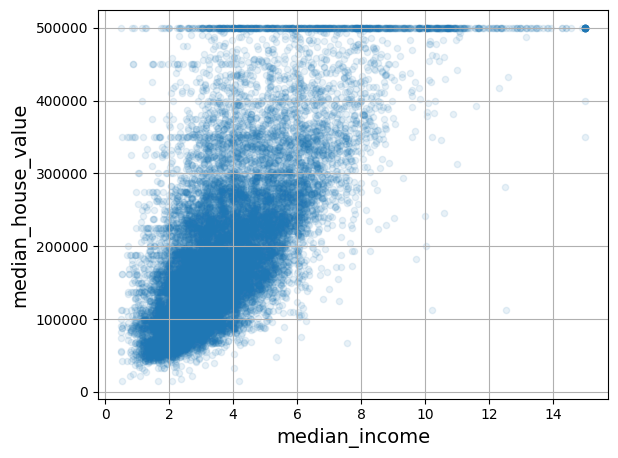

In [34]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

This plot reveals a few things:

+ The correlation is indeed quite strong; you can clearly see the upward trend, and the points are not too dispersed.
+ The price cap you noticed earlier is clearly visible as a horizontal line at $500,000. But the plot also reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that.

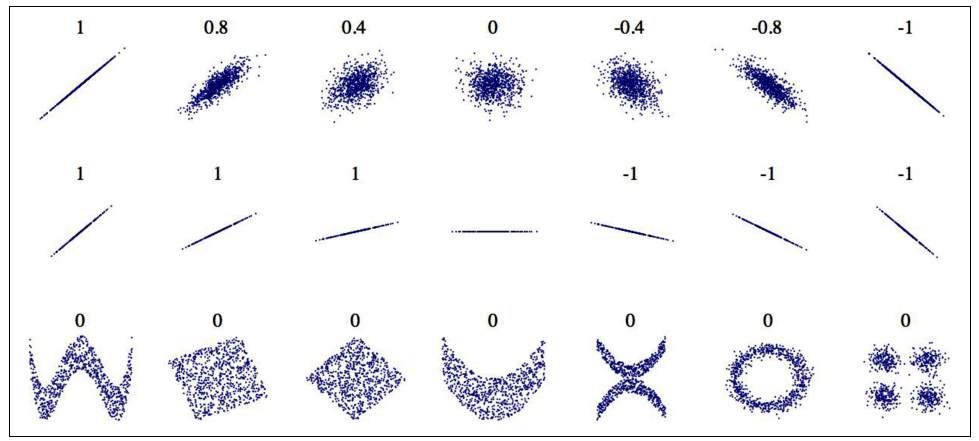

*Figure: Standard correlation coefficient of various datasets (source: Wikipedia; public domain image)*

## Experiment with Attribute Combinations

You identified a few data quirks that you may want to clean up before feeding the data to a machine learning algorithm, and you found interesting correlations between attributes, in particular with the target attribute. You also noticed that some attributes have a skewed-right distribution, so you may want to transform them (e.g., by computing their logarithm or square root).

One last thing you may want to do before preparing the data for machine learning algorithms is to try out various attribute combinations.

For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. You create these new attributes as follows:

In [35]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [36]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

The new `bedrooms_ratio` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district obviously the larger the houses, the more expensive they are.

# 4. Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [38]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


In [39]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

## Clean the Data

Most machine learning algorithms cannot work with missing features, so you’ll need to take care of these. For example, you noticed earlier that the `total_bedrooms` attribute has some missing values. You have three options to fix this:

1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median, etc.). This is called imputation.

You can accomplish these easily using the Pandas DataFrame’s `dropna()`, `drop()`, and `fillna()` methods:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [40]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [41]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [42]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [43]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

/tmp/ipykernel_12279/3218827148.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


You decide to go for option 3 since it is the least destructive, but instead of the preceding code, you will use a handy Scikit-Learn class: `SimpleImputer`. The benefit is that it will store the median value of each feature: this will make it possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model. To use it, first you need to create a `SimpleImputer` instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [44]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [45]:
housing_num = housing.select_dtypes(include=[np.number])
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [46]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The `imputer` has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing values, but you cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the `imputer` to all the numerical attributes:

In [47]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Check that this is the same as manually computing the median of each attribute:

In [48]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this “trained” `imputer` to transform the training set by replacing missing values with the learned medians:

In [49]:
X = imputer.transform(housing_num)

Missing values can also be replaced with the mean value (`strategy="mean"`), or with the most frequent value (`strategy="most_frequent"`), or with a constant value (`strategy="constant", fill_value=…`). The last two strategies support non-numerical data.

In [50]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matrices) even when they are fed Pandas DataFrames as input. So, the output of `imputer.transform(housing_num)` is a NumPy array: `X` has neither column names nor index. Luckily, it’s not too hard to wrap `X` in a DataFrame and recover the column names and index from `housing_num`:

In [51]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [52]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [53]:
imputer.strategy

'median'

Now let's drop some outliers:

In [54]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

The `IsolationForest` is a machine learning algorithm that is used for anomaly detection. It belongs to the `sklearn.ensemble` module in the scikit-learn library. Anomaly detection refers to the task of identifying observations that deviate significantly from the majority of the data. These observations are often referred to as outliers. ([see](https://www.youtube.com/watch?v=O9VvmWj-JAk))

In [55]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [56]:
housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

## Handling Text and Categorical Attributes

So far we have only dealt with numerical attributes, but your data may also contain text attributes. In this dataset, there is just one: the `ocean_proximity` attribute. Let’s look at its value for the first few instances:

In [57]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN


Most machine learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder` class:

In [58]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [59]:
housing_cat_encoded[:8]

array([[0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.]])

In [60]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, and “excellent”), but it isobviously not the case for the `ocean_proximity` column (for example, categories 0and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "`<1H OCEAN`" (and 0 otherwise), another attribute equal to 1 when the
category is "`INLAND`" (and 0 otherwise), and so on. This is called *one-hot encoding*, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy* attributes. Scikit-Learn provides a `OneHotEncoder` class to convert categorical values into one-hot vectors:

In [61]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [62]:
housing_cat_1hot

<14448x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14448 stored elements in Compressed Sparse Row format>

By default, the output of a `OneHotEncoder` is a SciPy sparse matrix, instead of a NumPy array.

A sparse matrix is a very efficient representation for matrices that contain mostly zeros. You can use a sparse matrix mostly like a normal 2D array, but if you want to convert it to a (dense) NumPy array, just call the `toarray()` method:

In [63]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set `sparse_output=False` when creating the `OneHotEncoder` (note: the `sparse` hyperparameter was renamned to `sparse_output` in Scikit-Learn 1.2):

In [64]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [65]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas has a function called `get_dummies()`, which also converts each categorical feature into a one-hot representation, with one binary feature per category:

In [66]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


Why not use it instead of `OneHotEncoder`? The advantage of `OneHotEncoder` is that it remembers which categories it was trained on. This is very important because once your model is in production, it should be fed exactly the same features as during training: no more, no less. Look what our trained `cat_encoder` outputs when we make it transform the same `df_test` (using `transform()`, not `fit_transform()`):

In [67]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

See the difference? `get_dummies()` saw only two categories, so it output two columns, whereas `OneHotEncoder` output one column per learned category, in the right order. Moreover, if you feed `get_dummies()` a DataFrame containing an unknown category (e.g., "`<2H OCEAN`"), it will happily generate a column for it:

In [68]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


But `OneHotEncoder` is smarter: it will detect the unknown category and raise an exception. If you prefer, you can set the `handle_unknown` hyperparameter to `"ignore"`, in which case it will just represent the unknown category with zeros:

In [69]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [70]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [71]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [72]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown), columns=cat_encoder.get_feature_names_out(), index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


## Feature Scaling and Transformation

With few exceptions, machine learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Without any scaling, most models will be biased toward ignoring the median income and focusing more on the number of rooms.

There are two common ways to get all attributes to have the same scale: *min-max scaling* and *standardization*.

Min-max scaling (many people call this normalization) is the simplest: for each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. This is performed by subtracting the min value and dividing by the difference between the min and the max.

In [73]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) # `feature_range` hyperparameter that lets you change the range if, for some reason, you don’t want 0 - 1
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Standardization is different: first it subtracts the mean value, then it divides the result by the standard deviation. Unlike min-max scaling, standardization does not restrict values to a specific range. However, standardization is much less affected by outliers.

In [74]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

When a feature’s distribution has a heavy tail both min-max scaling and standardization will squash most values into a small range. Machine learning models generally don’t like this at all, so before you scale the feature, you should first transform it to shrink the heavy tail, and if possible to make the distribution roughly symmetrical. For example, a common way to do this for positive features with a heavy tail to the right is to replace the feature with its square root (or raise the feature to a power between 0 and 1). If the feature has a really long and heavy tail, such as a power law distribution, then replacing the feature with its logarithm may help. For example, the `population` feature roughly follows a power law: districts with 10,000 inhabitants are only 10 times less frequent than districts with 1,000 inhabitants, not exponentially less frequent.

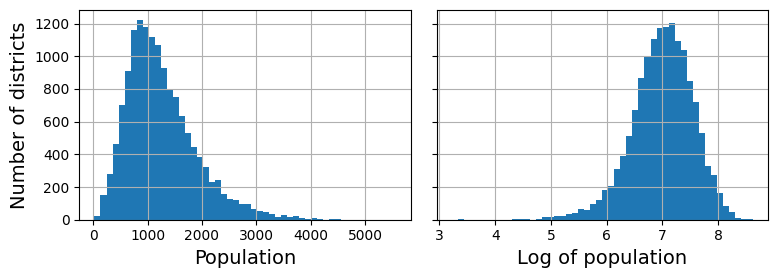

In [75]:
# extra code
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
"""
The `sharey` parameter in the subplots function is used to share the y-axis between subplots in a figure. 
When you set `sharey=True`, the subplots will share the same y-axis, which means the graphs in the subplots will have the same y-axis range.
"""
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

*Figure: Transforming a feature to make it closer to a Gaussian distribution*

What if we replace each value with its percentile?

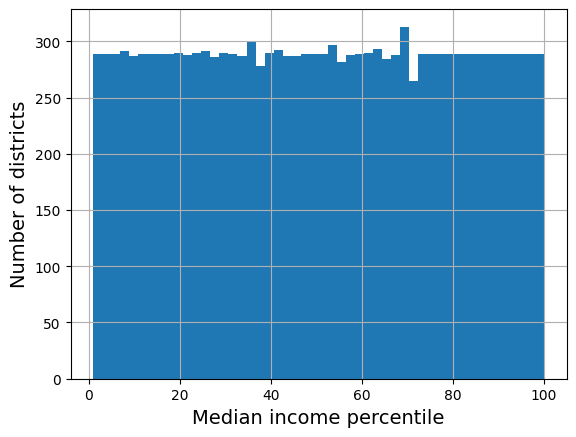

In [76]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"], bins=[-np.inf] + percentiles + [np.inf], labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

Another approach to handle heavy-tailed features consists in bucketizing the feature. This means chopping its distribution into roughly equal-sized buckets, and replacing each feature value with the index of the bucket it belongs to, much like we did to create the `income_cat` feature (although we only used it for stratified sampling). For example, you could replace each value with its percentile. Bucketizing with equal-sized buckets results in a feature with an almost uniform distribution, so there’s no need for further scaling, or you can just divide by the number of buckets to force the values to the 0–1 range.

Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a *radial basis function* (RBF) - any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. For example, the Gaussian RBF similarity between the housing age x and 35 is given by the equation $e^{-\gamma(x - 35)^2}$. The hyperparameter $\gamma$ determines how quickly the similarity measure decays as x moves away from 35. Using Scikit-Learn’s `rbf_kernel()` function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

In [77]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

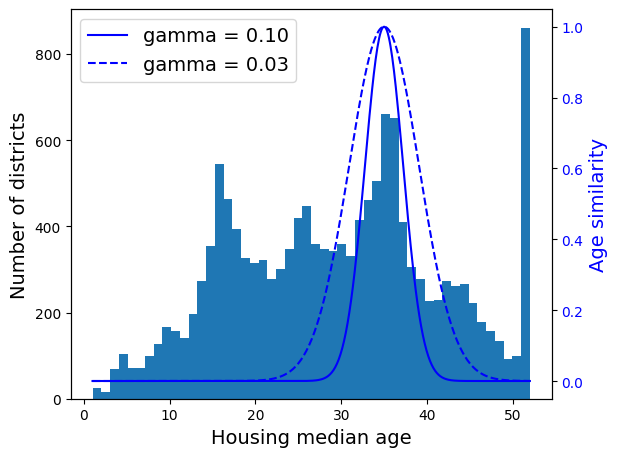

In [78]:
# extra code – this cell generates Figure 2–18

ages = np.linspace(housing["housing_median_age"].min(), housing["housing_median_age"].max(), 500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

The figure shows this new feature as a function of the housing median age (solid line). It also shows what the feature would look like if you used a smaller $\gamma$ value. As the chart shows, the new age similarity feature peaks at 35, right around the spike in the housing median age distribution: if this particular age group is well correlated with lower prices, there’s a good chance that this new feature will help.

So far we’ve only looked at the input features, but the target values may also need to be transformed. For example, if the target distribution has a heavy tail, you may choose to replace the target with its logarithm. But if you do, the regression model will now predict the log of the median house value, not the median house value itself. You will need to compute the exponential of the model’s prediction if you want the predicted median house value.

Luckily, most of Scikit-Learn’s transformers have an `inverse_transform()` method, making it easy to compute the inverse of their transformations. For example, the following code example shows how to scale the labels using a `StandardScaler` (just like we did for inputs), then train a simple linear regression model on the resulting scaled labels and use it to make predictions on some new data, which we transform back to the original scale using the trained scaler’s `inverse_transform()` method. Note that we convert the labels from a Pandas Series to a DataFrame, since the `StandardScaler` expects 2D inputs. Also, in this example we just train the model on a single raw input feature (median income), for simplicity:

In [79]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [80]:
predictions

array([[307649.58358784],
       [143451.50154782],
       [135759.63057829],
       [192702.83891231],
       [184498.77560018]])

This works fine, but a simpler option is to use a `TransformedTargetRegressor`. We just need to construct it, giving it the regression model and the label transformer, then fit it on the training set, using the original unscaled labels. It will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels, just like we did previously. Then, when we want to make a prediction, it will call the regression model’s `predict()` method and use the scaler’s `inverse_transform()` method to produce the prediction:

In [81]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels.to_frame())
predictions = model.predict(some_new_data)

In [82]:
predictions

array([[307649.58358784],
       [143451.50154782],
       [135759.63057829],
       [192702.83891231],
       [184498.77560018]])

## Custom Transformers

For transformations that don’t require any training, you can just write a function that takes a NumPy array as input and outputs the transformed array. For example, as discussed in the previous section, it’s often a good idea to transform features with heavy-tailed distributions by replacing them with their logarithm (assuming the feature is positive and the tail is on the right). Let’s create a log-transformer and apply it to the population feature:

In [83]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) 
# `inverse_func` argument is optional. It lets you specify an inverse transform function, e.g., if you plan to use your transformer in a TransformedTargetRegressor.
log_pop = log_transformer.transform(housing[["population"]])

Your transformation function can take hyperparameters as additional arguments. For example, here’s how to create a transformer that computes the same Gaussian RBF similarity measure as earlier:

In [84]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [85]:
age_simil_35

array([[8.20849986e-02],
       [6.70320046e-01],
       [8.48904403e-15],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

Note that there’s no inverse function for the RBF kernel, since there are always two values at a given distance from a fixed point (except at distance 0). Also note that `rbf_kernel()` does not treat the features separately. If you pass it an array with two features, it will measure the 2D distance (Euclidean) to measure similarity. For example, here’s how to add a feature that will measure the geographic similarity between each district and San Francisco:

In [86]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [87]:
sf_simil

array([[0.05258419],
       [0.94864161],
       [0.01192662],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

Custom transformers are also useful to combine features. For example, here’s a `FunctionTransformer` that computes the ratio between the input features 0 and 1:

In [88]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

`FunctionTransformer` is very handy, but what if you would like your transformer to be trainable, learning some parameters in the `fit()` method and using them later in the `transform()` method? For this, you need to write a custom class. Scikit-Learn relies on duck typing, so this class does not have to inherit from any particular base class. All it needs is three methods: `fit()` (which must return self), `transform()`, and `fit_transform()`.

You can get `fit_transform()` for free by simply adding `TransformerMixin` as a base class: the default implementation will just call `fit()` and then `transform()`. If you add `BaseEstimator` as a base class (and avoid using `*args` and `**kwargs` in your constructor), you will also get two extra methods: `get_params()` and `set_params()`. These will be useful for automatic hyperparameter tuning.

For example, here’s a custom transformer that acts much like the `StandardScaler`:

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # The `check_is_fitted()` function is used to check whether `self` has been trained or not.
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        """
        The above code checks whether the number of features in the trained model (`self.n_features_in_`) is equal to the number of features in the input data (`X.shape[1]`).
        If these two values ​​are not equal, an error will be thrown to signal that the input data is not compatible with the trained model.
        """
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Here are a few things to note:

+ The `sklearn.utils.validation` package contains several functions we can use to validate the inputs. For simplicity, we will skip such tests in the rest of this book, but production code should have them.
+ Scikit-Learn pipelines require the `fit()` method to have two arguments `X` and `y`, which is why we need the `y=None` argument even though we don’t use `y`.
+ All Scikit-Learn estimators set `n_features_in_` in the `fit()` method, and they ensure that the data passed to `transform()` or `predict()` has this number of features.
+ The `fit()` method must return self.
+ This implementation is not 100% complete: all estimators should set `feature_names_in_` in the `fit()` method when they are passed a DataFrame. Moreover, all transformers should provide a `get_feature_names_out()` method, as well as an `inverse_transform()` method when their transformation can be reversed. See the last exercise at the end of this chapter for more details.

A custom transformer can (and often does) use other estimators in its implementation. For example, the following code demonstrates custom transformer that uses a KMeans clusterer in the `fit()` method to identify the main clusters in the training data, and then uses `rbf_kernel()` in the `transform()` method to measure how similar each sample is to each cluster center:

In [90]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

Now let’s use this custom transformer:

In [91]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

In [92]:
similarities[:3].round(2)

array([[0.  , 0.99, 0.04, 0.  , 0.  , 0.  , 0.  , 0.65, 0.  , 0.34],
       [0.47, 0.  , 0.  , 0.7 , 0.  , 0.  , 0.29, 0.  , 0.17, 0.  ],
       [0.  , 0.22, 0.49, 0.  , 0.  , 0.  , 0.  , 0.62, 0.  , 0.  ]])

Figure shows the 10 cluster centers found by k-means. The districts are colored according to their geographic similarity to their closest cluster center. As you can see, most clusters are located in highly populated and expensive areas.

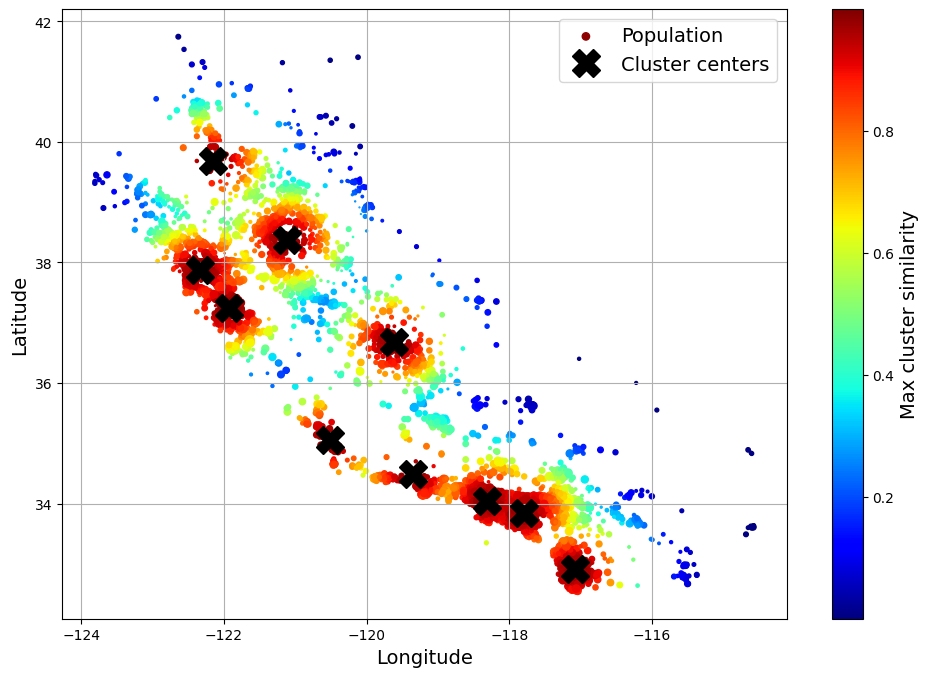

In [93]:
# extra code

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

## Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the `Pipeline` class to help with such sequences of transformations. Here is a small pipeline for numerical attributes, which will first impute then scale the input features:

In [94]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

If you don’t want to name the transformers, you can use the `make_pipeline()` function instead

In [95]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In a Jupyter notebook, if you `import sklearn` and run `sklearn.set_config(display="diagram")`, all Scikit-Learn estimators will be rendered as interactive diagrams. This is particularly useful for visualizing pipelines. To visualize `num_pipeline`, run a cell with `num_pipeline` as the last line. Clicking an estimator will show more details.

In [96]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

Let’s call the pipeline’s `fit_transform()` method and look at the output’s first two rows, rounded to two decimal places:

In [97]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [98]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [99]:
df_housing_num_prepared.head(2)  # extra code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [100]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [101]:
num_pipeline[1]

StandardScaler()

In [102]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [103]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [104]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

So far, we have handled the categorical columns and the numerical columns separately. For this, you can use a `ColumnTransformer`:

In [105]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Since listing all the column names is not very convenient, Scikit-Learn provides a `make_column_selector()` function that returns a selector function you can use to automatically select all the features of a given type, such as numerical or categorical. You can pass this selector function to the `ColumnTransformer` instead of column names or indices. Moreover, if you don’t care about naming the transformers, you can use `make_column_transformer()`, which chooses the names for you, just like `make_pipeline()` does. For example, the following code creates the same ColumnTransformer as earlier, except the transformers are automatically named `"pipeline-1"` and `"pipeline-2"` instead of `"num"` and `"cat"`:

In [106]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [107]:
housing_prepared = preprocessing.fit_transform(housing)

In [108]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
14973,0.595527,-0.692801,0.875904,-0.257539,-0.479342,-0.911423,-0.367756,1.383990,1.0,0.0,0.0,0.0,0.0
3785,-1.273032,1.361924,0.292345,-1.043780,-1.077558,-1.073350,-1.092179,-0.804668,0.0,1.0,0.0,0.0,0.0


Let’s recap what the pipeline will do and why:

+ Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don’t expect missing values. In categorical features, missing values will be replaced by the most frequent category.
+ The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs.
+ A few ratio features will be computed and added: `bedrooms_ratio`, `rooms_per_house`, and `people_per_house`. Hopefully these will better correlate with the median house value, and thereby help the ML models.
+ A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.
+ Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions.
+ All numerical features will be standardized, as most ML algorithms prefer when all features have roughly the same scale.

The code that builds the pipeline to do all of this should look familiar to you by now:

In [109]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [110]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(14448, 24)

In [111]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# 5. Select and Train a Model

## Train and Evaluate on the Training Set

You decide to train a very basic linear regression model to get started:

In [112]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x763...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x76320c888550>)])),
                ('linearregression', LinearRegression())])

Let's try the full preprocessing pipeline on a few training instances:

In [113]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([379800., 122500.,  99600., 341400., 200300.])

Compare against the actual values:

In [114]:
housing_labels.iloc[:5].values

array([483800., 101700.,  96100., 361800.,  92600.])

Well, it works, but not always: the first prediction is way off (by over $200,000!), while the other predictions are better: two are off by about 25%, and two are off by less than 10%. Remember that you chose to use the RMSE as your performance measure, so you want to measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error()` function, with the squared argument set to `False`:

In [115]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-21.5%, 20.5%, 3.6%, -5.6%, 116.3%


In [116]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


65778.48225643061

This is better than nothing, but clearly not a great score: the median_housing_values of most districts range between $120,000 and $265,000, so a typical prediction error of $68,628 is really not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we know, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features, but first you want to try a more complex model to see how it does.

You decide to try a `DecisionTreeRegressor`, as this is a fairly powerful model capable of finding complex nonlinear relationships in the data:

In [117]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x763...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x76320c888550>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [118]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0

## Better Evaluation Using Cross-Validation

One way to evaluate the decision tree model would be to use the `train_test_split()` function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of effort, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn’s *k-fold cross-validation* feature. The following code randomly splits the training set into 10 nonoverlapping subsets called folds, then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and using the other 9 folds for training. The result is an array containing the 10 evaluation scores:

In [119]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the RMSE. It’s a
negative value, so you need to switch the sign of the output to get the RMSE scores.

In [120]:
tree_rmses

array([64477.50389409, 64160.83497492, 63184.71914307, 62691.12961018,
       69028.07076996, 64599.49579462, 70267.78006163, 66504.36970975,
       63700.31785343, 67145.39970824])

In [121]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     65575.962152
std       2559.867825
min      62691.129610
25%      63815.447134
50%      64538.499844
75%      66985.142209
max      70267.780062
dtype: float64

In [122]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     67856.971843
std       4282.797978
min      63653.224894
25%      65648.552875
50%      67242.573995
75%      68167.274730
max      79024.043455
dtype: float64

Now the decision tree doesn’t look as good as it did earlier. In fact, it seems to perform almost as poorly as the linear regression model! If you compute the same metric for the linear regression model, you will find that the mean RMSE is 69,858 and the standard deviation is 4,182. So the decision tree model seems to perform very slightly better than the linear model, but the difference is minimal due to severe overfitting.

Let’s try one last model now: the `RandomForestRegressor`. Random forests work by training many decision trees on random subsets of the features, then averaging out their predictions.

In [124]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

In [125]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     45712.814157
std       1526.379944
min      43581.732899
25%      44586.595164
50%      45444.484552
75%      47069.509995
max      47938.112716
dtype: float64

Random forests really look very promising for this task! However, if you train a RandomForest and measure the RMSE on the training set, you will find roughly 16,952: that’s much lower, meaning that there’s still quite a lot of overfitting going on. Possible solutions are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.

In [126]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


16952.579457730448

# 6. Fine-Tune Your Model

## Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you can use Scikit-Learn’s `GridSearchCV` class to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. For example, the following code searches for the best combination of hyperparameter values for the `RandomForestRegressor`:

In [127]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x76320c888550>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

When Scikit-Learn sees `"preprocessing__geo__n_clusters"`, it splits this string at the double underscores, then it looks for an estimator named `"preprocessing"` in the pipeline and finds the preprocessing `ColumnTransformer`. Next, it looks for a transformer named `"geo"` inside this `ColumnTransformer` and finds the `ClusterSimilarity` transformer we used on the `latitude` and `longitude` attributes. Then it finds this transformer’s `n_clusters` hyperparameter. Similarly, `random_forest__max_features` refers to the `max_features` hyperparameter of the estimator named `"random_forest"`, which is of course the `RandomForest` model

In [128]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'prepr

The best hyperparameter combination found:

In [129]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In this example, the best model is obtained by setting `n_clusters` to 15 and setting `max_features` to 6.

You can access the best estimator using `grid_search.best_estimator_.` If `GridSearchCV` is initialized with `refit=True` (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea, since feeding it more data will likely improve its performance.

In [130]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x76320c1...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7631e79ebd00>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

The evaluation scores are available using `grid_search.cv_results_`. This is a dictionary, but if you wrap it in a DataFrame you get a nice list of all the test scores for each combination of hyperparameters and for each cross-validation split, as well as the mean test score across all splits:

In [133]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,41811,43463,42184,42486
13,15,8,42086,44078,42782,42982
14,15,10,42644,44122,42921,43229
7,10,6,43255,44499,43575,43776
9,10,6,43255,44499,43575,43776


The mean test RMSE score for the best model is 42,486, which is better than the score you got earlier using the default hyperparameter values (which was 45,712).

## Randomized Search

The grid search approach is fine when you are exploring relatively few combinations but `RandomizedSearchCV` is often preferable, especially when the hyperparameter search space is large. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations it evaluates a fixed number of combinations, selecting a random value for each hyperparameter at every iteration.

In [134]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 (`n_iter` $\times$ `cv`) random combinations of hyperparameters:

In [135]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7631e79e8370>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x76320c14e110>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [136]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,39937,42053,40021,40670
8,32,7,40366,42252,40730,41116
5,42,4,40581,42688,40947,41405
0,41,16,40695,42780,41005,41493
2,23,8,41073,42910,41655,41879


**Bonus section: how to choose the sampling distribution for a hyperparameter**

+ `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
+ `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
+ `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
+ `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
+ `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.

Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

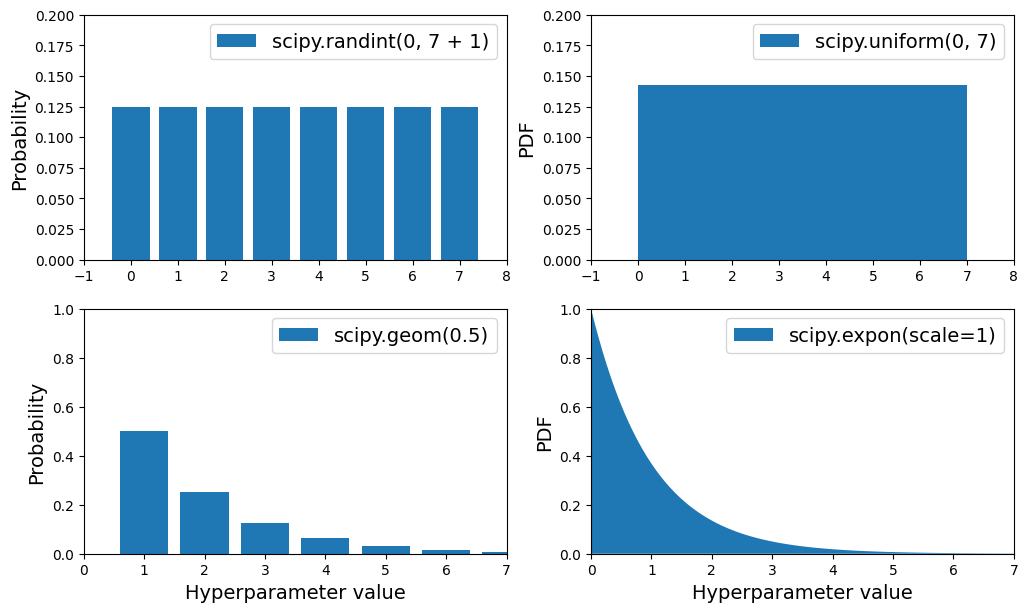

In [137]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `loguniform()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `loguniform()` does not favor any scale, they are all equally likely:

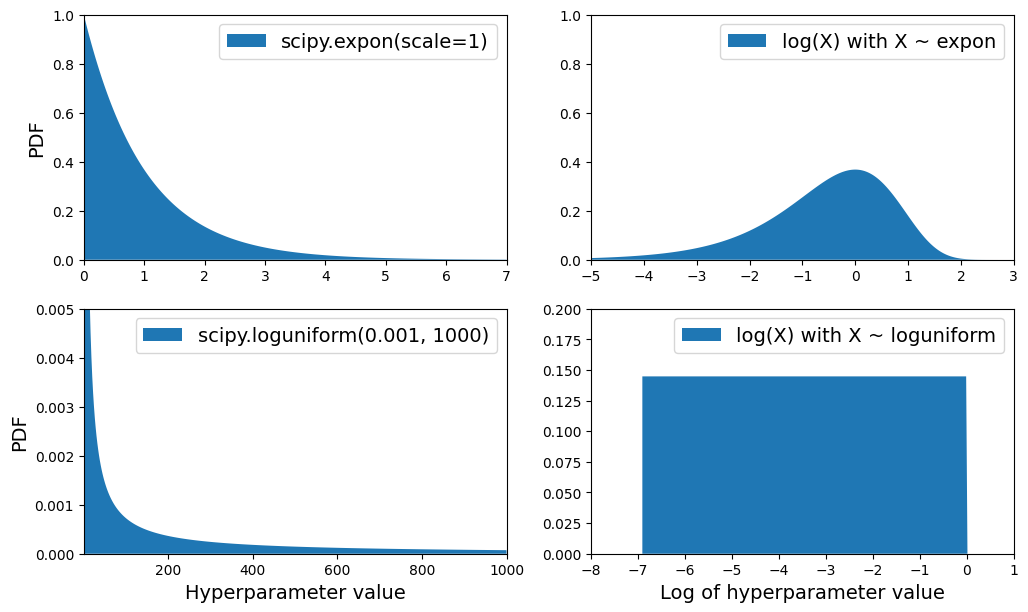

In [138]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib, label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib, label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib, label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib, label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analyzing the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions:

In [139]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.05, 0.06, 0.01, 0.01, 0.01, 0.01, 0.17, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.01, 0.03,
       0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.03,
       0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.04,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [140]:
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.1735454119679924, 'log__median_income'),
 (0.06788378064362875, 'cat__ocean_proximity_INLAND'),
 (0.06284306674308061, 'bedrooms__ratio'),
 (0.057266721148780675, 'people_per_house__ratio'),
 (0.047938255005602184, 'rooms_per_house__ratio'),
 (0.03605973265373645, 'geo__Cluster 35 similarity'),
 (0.02740298239593355, 'geo__Cluster 34 similarity'),
 (0.026558025819255482, 'geo__Cluster 24 similarity'),
 (0.025564900634172147, 'geo__Cluster 13 similarity'),
 (0.020614857261579946, 'geo__Cluster 3 similarity'),
 (0.01995233933371085, 'geo__Cluster 16 similarity'),
 (0.018806465147058166, 'geo__Cluster 28 similarity'),
 (0.018804689229477645, 'geo__Cluster 44 similarity'),
 (0.01480862449668886, 'geo__Cluster 30 similarity'),
 (0.013952583807453114, 'geo__Cluster 14 similarity'),
 (0.013606875161042893, 'geo__Cluster 42 similarity'),
 (0.013091955631562967, 'geo__Cluster 6 similarity'),
 (0.01284937882631878, 'geo__Cluster 19 similarity'),
 (0.012433459540703365, 'geo__Cluster 15 simil

With this information, you may want to try dropping some of the less useful features.

## Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. You are ready to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set and run your `final_model` to transform the data and make predictions, then evaluate these predictions:

In [141]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

42537.741264526725


/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using `scipy.stats.t.interval()`.

In [143]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([40383.7841013 , 44587.76564748])

We could compute the interval manually like this:

In [144]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(40383.784101304176, 44587.7656474833)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:

In [145]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(40384.43265129599, 44587.17823779139)

## Model persistence using `joblib`

Save the final model:

In [146]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Now you can deploy this model to production. For example, the following code could be a script that would run in production:

In [147]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [148]:
predictions

array([461235.08, 108850.  , 101274.  , 338081.02, 104453.  ])

# Exercises

## 1. 

Excercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now. How does the best `SVR` predictor perform?_

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300., 1000.0], 'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x76320c888550>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [150]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

68379.38577376705

That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found:

In [151]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._

In [152]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `loguniform()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline, param_distributions=param_distribs, n_iter=50, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x76320c888550>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7631e77fb400>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7631e7958eb0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [153]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

55053.060196171515

Now that's really much better, but still far from the `RandomForestRegressor`'s performance. Let's check the best hyperparameters found:

In [154]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [155]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)  # get 100,000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

0.80066

We used the `loguniform()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

## 3.

Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor:

In [156]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42), threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"], gamma=rnd_search.best_params_["svr__gamma"], kernel=rnd_search.best_params_["svr__kernel"])),
])

In [157]:
selector_rmses = -cross_val_score(selector_pipeline, housing.iloc[:5000], housing_labels.iloc[:5000], scoring="neg_root_mean_squared_error", cv=3)
pd.Series(selector_rmses).describe()

count        3.000000
mean     55392.006808
std       2290.497460
min      53430.579600
25%      54133.375789
50%      54836.171978
75%      56372.720412
max      57909.268847
dtype: float64

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?

## 4.

Exercise: _Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts._

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor. The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

In [158]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1) # If there is no `"n_outputs_"` attribute, the default value returned is `1`
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}" for i in range(n_outputs)]

Let's ensure it complies to Scikit-Learn's API:

In [159]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

Good! Now let's test it:

In [160]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[435250.        ],
       [101400.        ],
       [ 96100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]])

And what does its output feature name look like?

In [161]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']

Okay, now let's include this transformer in our preprocessing pipeline:

In [162]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns) for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [163]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [164]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline, housing.iloc[:5000], housing_labels.iloc[:5000], scoring="neg_root_mean_squared_error", cv=3)
pd.Series(new_pipe_rmses).describe()

count         3.000000
mean     102863.062310
std        1269.187970
min      102008.238188
25%      102133.896560
50%      102259.554931
75%      103290.474371
max      104321.393812
dtype: float64

Yikes, that's terrible! Apparently the cluster similarity features were much better. But perhaps we should tune the `KNeighborsRegressor`'s hyperparameters? That's what the next exercise is about.

## 5.

Exercise: _Automatically explore some preparation options using `RandomSearchCV`._

In [165]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline, param_distributions=param_distribs, n_iter=50, cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x76320c145120>,
                                                                                                                    func=<function column_ratio at 0x76320c70edd0>)),
                                                                                               ('standardscaler',
                                                                                                StandardSc...
                   param_distributions={'preprocessing__geo__estimator__n_neighbors': range(1, 30),
                                        'preprocessing__geo__estimator__weights': ['distance',
                                                                                   'uniform'],
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7631e6caff10>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7631e6cae620>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [166]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

102870.87070786

Oh well... at least we tried! It looks like the cluster similarity features are definitely better than the KNN feature. But perhaps you could try having both? And maybe training on the full training set would help as well.

## 6.

Exercise: _Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined, then `input_features` should be returned. If `input_features` is `None`, then the method should return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise._

In [167]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

Let's test our custom transformer:

In [168]:
from sklearn.utils.estimator_checks import check_estimator
 
check_estimator(StandardScalerClone())

No errors, that's a great start, we respect the Scikit-Learn API.

Now let's ensure the transformation works as expected:

In [169]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

How about setting `with_mean=False`?

In [170]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

And does the inverse work?

In [171]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

How about the feature names out?

In [172]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

And if we fit a DataFrame, are the feature in and out ok?

In [173]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])

___
## **References:**

$[1].$ *Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow, 2023.*